## Autorotación en vuelo completamente horizontal

#### Autogiro en autorotación completamente horizontal

Determinar                                                           
a) velocidad máxima en vuelo horizontal, cond. estándar                   
b) Velocidad de ascenso máxima al despegue, cond. estándar                 
c) techo de servicio considerando que la potencia del motor disminuye con el incremento de altura                                                    

Gw = 450 kg                                                              
Power Plant = 100 hp                                                  
Main rotor diameter = 8.4 m                                                
Propeller efficiency = 0.7                                                
Equivalent flat plate area = $6 ft^2$

a) para determinar la velocidad máxima debemos determinar la combinación de velocidad y ángulo de ataque que requieren la potencia disponible del motor
                                                                          
$P_{SHP} = \frac{T_p V_{oo}}{\eta_p}$

Para obtener $P_{PHP}$ requerimos $T_p$

$T_p = Tsin(\alpha) + Hcos(\alpha) + D_p$

$D_p = \frac{1}{2}\rho V_{oo}^2 s C_D$

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

Voo_Vh = [1.8, 1.8, 1.8, 1.8,  3,  4, 4.25, 4.52,  6,  6.4,    8,   9]
alpha =   [80,   60,  40,  30, 10,  7,    6,    5,  4,    3,  3.5,   2]

class AutoGiro():
    def __init__(self, AG_Data, hdens, list_Voo_Vh = [0], alpha = [0]):
        '''Clase que calcula la Potencia requerida por la hélice del motor  
           para un AutoGiro en vuelo horizontal a una misma altitud
           Inputs: 
               AG_Data (diccionario): Datos del AutoGiro
               hdens (float): Altitud densidad
               list_Voo_Vh (list): Lista que contiene las relaciones de velocidad
                                   Voo/Vh
               alpha (list): Lista que corresponde al ángulo de las relaciones de 
                             velocidad de la lista Voo/Vh
        '''
        
        self.AG_Data = AG_Data
        
        self.W  = AG_Data['W']    # [N]
        self.Pd = AG_Data['Pd']   # [hp]
        self.D  = AG_Data['D']    # [m]
        self.n  = AG_Data['n']    # [1]
        self.f  = AG_Data['f']    # [1]
        self.A  = np.pi*(1/4)*(self.D)**2  # [m^2]
        
        self.hdens = hdens        # [feet]
        self.dens   = 1.225*(1-self.hdens*(0.00357/518.4))**(1/0.235)   # [kg/m^3]
        self.dens_ratio = self.dens/1.225   # [1]
        
        self.list_Voo_Vh = list_Voo_Vh
        self. alpha = alpha
        
        self.list_Dp   = [0 for i in Voo_Vh]   # [N]
        self.list_Tp   = [0 for i in Voo_Vh]   # [N]
        self.list_Pshp = [0 for i in Voo_Vh]   # [hp]
        self.list_Voo  = [0 for i in Voo_Vh]   # [m/s]
        self.list_T    = [0 for i in Voo_Vh]   # [N]
        self.list_Pc   = [0 for i in Voo_Vh]   # [hp]
        self.list_Vc   = [0 for i in Voo_Vh]   # [m/s]
        self.DF   = pd.DataFrame({'Voo/Vh': self.list_Voo_Vh, 'alpha':self.alpha})
        
    def calc_T(self):
        """Método que calcula el empuje a cada Voo/Vh
        """
        for i in range(len(self.list_Voo_Vh)):
            self.list_T[i] = self.W/np.cos(np.deg2rad(self.alpha[i]))
        
    def calc_Voo(self):
        """Método que calcula el valor de la velocidad de avance, Voo, a la hdens dada
        """
        i = 0
        for V in self.list_Voo_Vh:
            self.list_Voo[i] = V*(self.list_T[i]/(2*self.dens*self.A))**0.5
            i += 1
        
    def calc_Dp(self):
        """Método que calcula el valor de Dp a las Voo y hdens
        """
        i = 0
        for V in self.list_Voo:
            self.list_Dp[i] = 0.5*self.dens*(V**2)*self.f
            i += 1
        
    def calc_Tp(self):
        """Método que calcula el valor de Tp a las Voo y hdens
        """
        i = 0
        for V in self.list_Voo:
            self.list_Tp[i] = self.list_T[i]*np.sin(np.deg2rad(alpha[i])) + self.list_Dp[i]
            i += 1
            
    def calc_Pshp(self):
        """Método que calcula el valor de Pshp a las Voo y hdens
        """
        i = 0
        for V in self.list_Voo:
            self.list_Pshp[i] = (self.list_Tp[i]*self.list_Voo[i])/745.7
            i += 1
            
    def calc_Pc(self):
        """Método que calcula el valor de Pc a las Voo y hdens
        """
        i = 0
        for V in self.list_Voo:
            self.list_Pc[i] = self.dens_ratio*self.Pd*self.n - self.list_Pshp[i]
            i += 1
            
    def calc_Vc(self):
        """Método que calcula el valor de Vc a las Voo y hdens
        """
        i = 0
        for V in self.list_Voo:
            self.list_Vc[i] = 745.7*self.list_Pc[i]/self.list_T[i]
            i += 1
            
    def calc_All(self):
        """Método que calcula T, Voo, Dp, Tp, Pshp, Pc, Vc para una hdens dada
        """
        self.__init__(self.AG_Data, self.hdens, self.list_Voo_Vh, self.alpha)
        self.calc_T()
        self.calc_Voo()
        self.calc_Dp()
        self.calc_Tp()
        self.calc_Pshp()
        self.calc_Pc()
        self.calc_Vc()
            
    def data_frame(self):
        """Método que calcula las potencias y muestra el un Data Frame a la hdens dada
        """
        self.calc_All()
        
        DF_P = pd.DataFrame({'Voo [m/s]': np.round(self.list_Voo, 2), 'Pshp [hp]': np.round(self.list_Pshp, 2), 'Pc [hp]': np.round(self.list_Pc, 2), 'Vc [m/s]': np.round(self.list_Vc, 2)})
        self.DF = self.DF.join(DF_P)

        return self.DF
    
    def calc_techo(self, alt_inicial):
        """Método que varía la altitud densidad hasta encontrar el techo de servicio
           sólo lo hace para una Voo/Vh = 1.8 & alpha = 30°
           Inputs:
               alt_inicial (float): Altitud para comenzar a iterar 
           Outputs:
               Techo de servicio
        """
        Error = 10
        alt_dens = alt_inicial
        
        while Error > 0.01:
            self.hdens = alt_dens
            self.calc_All()
            P_R    = self.list_Pshp[3]
            P_disp = self.dens_ratio*self.Pd*self.n
            Error  = P_disp - P_R
            alt_dens += 0.1

        return f'Techo de servicio: {alt_dens} ft'
        
    #def vel_sigma(self, sigma):
    #    for j in range(len(sigma)):
    #       i = 0
    #        for x in self.list_Voo_Vh:
    #            self.list_T[i] = self.W/np.cos(np.deg2rad(self.alpha[i]))
    #            self.list_Voo[i] = x*(self.list_T[i]/(2*1.225*sigma[j]*self.A))**0.5
    #            i += 1
        
    #def calc_potencia(self, sigma = [1]):
    #    """Método que calcula Pshp & Pc para distintas velocidades Voo & alpha a la hdens dada
    #       También muestra la información en un Data Frame que incluye:
    #           Voo/Vh, alpha, Voo, Pshp, Pc
    #    """
    #    for j in range(len(sigma)):
    #        i = 0
    #        for x in self.list_Voo_Vh:
    #            self.list_T[i] = self.W/np.cos(np.deg2rad(self.alpha[i]))
    #            self.list_Voo[i] = x*(self.list_T[i]/(2*1.225*sigma[j]*self.A))**0.5
    #            self.list_Dp[i] = 0.5*1.225*sigma[j]*(self.list_Voo[i]**2)*self.f
    #            self.list_Tp[i] = self.list_T[i]*np.sin(np.deg2rad(alpha[i])) + self.list_Dp[i] 
    #            self.list_Pshp[i] = (self.list_Tp[i]*self.list_Voo[i]/self.n)/745.7
    #            self.list_Pc[i] = sigma[j]*100*self.n - self.list_Pshp[i]*self.n
    #            i += 1
    #        DF_P = pd.DataFrame({f'Voo_@s = {sigma[j]} [m/s]': np.round(self.list_Voo, 2), f'Pshp_@s = {sigma[j]} [hp]': np.round(self.list_Pshp, 2), f'Pc_@s = {sigma[j]} [hp]': np.round(self.list_Pc, 2)})
    #        self.DF = self.DF.join(DF_P)


In [2]:
AG1_Data = {'W': 450*9.81,
           'Pd': 100,
           'D' : 8.4,
           'n' : 0.7,
           'f' : 0.557418
            }

In [16]:
AG1_prueba = AutoGiro(AG1_Data, 0, Voo_Vh, alpha)

In [17]:
AG1_prueba.calc_All()
AG1_prueba.data_frame()

,Voo/Vh,alpha,Voo [m/s],Pshp [hp],Pc [hp],Vc [m/s]
0,1.80,80.0,24.63,833.77,-763.77,-22.40
1,1.80,60.0,14.52,150.23,-80.23,-6.78
2,1.80,40.0,11.73,58.99,11.01,1.42
3,1.80,30.0,11.03,38.31,31.69,4.64
4,3.00,10.0,17.24,20.34,49.66,8.26
5,4.00,7.0,22.89,22.13,47.87,8.03
6,4.25,6.0,24.30,21.69,48.31,8.12
7,4.52,5.0,25.82,21.26,48.74,8.20
8,6.00,4.0,34.25,32.58,37.42,6.31
9,6.40,3.0,36.52,33.63,36.37,6.14


In [12]:
AG1_prueba.calc_techo(12000)

'Techo de servicio: 13081.000000003933 ft'

In [14]:
AG1_prueba.dens_ratio

0.6691759505181303

### a) Velocidad Máxima a nivel del mar

Para conocer la velocidad máxima debemos saber a que velocidad la Potencia requerida por la propela (Pshp) es igual             
a la potencia que puede suministrar el motor

In [9]:
AG1 = AutoGiro(Voo_raw, alpha)
AG1.potencia()
AG1.DF

,Voo/Vh,alpha,Voo_@s = 1 [m/s],Pshp_@s = 1 [hp],Pc_@s = 1 [hp]
0,1.80,80.0,24.63,1191.10,-763.77
1,1.80,60.0,14.52,214.62,-80.23
2,1.80,40.0,11.73,84.27,11.01
3,1.80,30.0,11.03,54.73,31.69
4,3.00,10.0,17.24,29.06,49.66
5,4.00,7.0,22.89,31.62,47.87
6,4.25,6.0,24.30,30.99,48.31
7,4.52,5.0,25.82,30.37,48.74
8,6.00,4.0,34.25,46.55,37.42
9,6.40,3.0,36.52,48.04,36.37


### Test

Con alpha = 4 & Voo/Vh = 6                                                     
T = 4425.27 N                                                                                                          
P = 46 hp                                                                                                                   

Con alpha = 2 & Voo/Vh = 9                                                  
Voo = 51.33 m/s

In [15]:
print(f'T    =  {round(AG1.T[8],2)} N')
print(f'Dp   =  {round(AG1.Dp[8],2)} N')
print(f'Pshp = {round(AG1.Pshp[8],2)} hp')

T    =  4425.28 N
Dp   =  400.6 N
Pshp = 46.55 hp


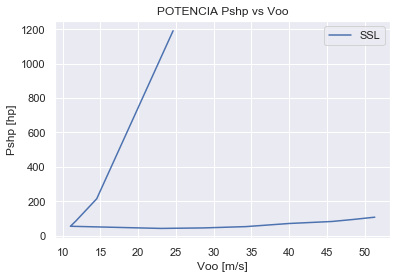

In [25]:
plt.plot(AG1.Voo,AG1.Pshp, label = 'SSL')
plt.title('POTENCIA Pshp vs Voo')
plt.xlabel('Voo [m/s]')
plt.ylabel('Pshp [hp]')
plt.legend()
plt.show()

### b) Máxima velocidad de ascenso

Para entrar en autorotación (comenzar a ascender) requerimos Voo/Vh = 1.8 y el ángulo que nos demanda menor potencia es $\alpha = 30°$                      
                                                                       
Podemos decir que Voo es la velocidad de stall, ya que es la mínima para entrar en autorotación                                                              

Para la máxima velocidad de ascenso necesitamos $P_c$ máxima                                             
$P_c = P_d - P_R$      
$P_c = TV_c$                                                                                               
$P_d = 100hp(\eta_p)$


In [13]:
AG2 = AutoGiro(Voo_raw, alpha)
AG2.potencia()
Vc = AG2.Pc[3]*745.7/AG2.T[3]
Vc

4.6358513045502825

### Tests
Voo = 11.03 m/s                                                               
T = 5097.43 N                                                                
Vc = 4.63 m/s

In [24]:
print(f'Voo = {round(AG2.Voo[3], 2)} m/s')
print(f'T = {round(AG2.T[3], 2)} N')
print(f'Vc = {round(Vc, 2)} m/s')

Voo = 11.03 m/s
T = 5097.43 N
Vc = 4.64 m/s


### c) Techo de servicio

Debemos calcular las potencias necesarias con diferentes densidades, hasta que una densidad arroje una potencia mínima igual a la disponible de 100 hp                                                                                
$\sigma = e^{-h/\beta}$                                                                                                       
$\beta = 9296 m$

In [59]:
sigma = [1, 0.7, 0.669]

In [60]:
AG_sigma = AutoGiro(Voo_raw, alpha)
AG_sigma.potencia(sigma)
AG_sigma.DF

,Voo/Vh,alpha,Voo_@s = 1 [m/s],Pshp_@s = 1 [hp],Pc_@s = 1 [hp],Voo_@s = 0.7 [m/s],Pshp_@s = 0.7 [hp],Pc_@s = 0.7 [hp],Voo_@s = 0.669 [m/s],Pshp_@s = 0.669 [hp],Pc_@s = 0.669 [hp]
0,1.80,80.0,24.63,1191.10,-763.77,29.44,1423.64,-947.55,30.11,1456.25,-972.55
1,1.80,60.0,14.52,214.62,-80.23,17.35,256.52,-130.56,17.75,262.39,-136.85
2,1.80,40.0,11.73,84.27,11.01,14.02,100.72,-21.51,14.34,103.03,-25.29
3,1.80,30.0,11.03,54.73,31.69,13.18,65.41,3.21,13.48,66.91,-0.01
4,3.00,10.0,17.24,29.06,49.66,20.60,34.73,24.69,21.07,35.52,21.96
5,4.00,7.0,22.89,31.62,47.87,27.36,37.79,22.54,27.99,38.66,19.77
6,4.25,6.0,24.30,30.99,48.31,29.04,37.04,23.08,29.71,37.88,20.31
7,4.52,5.0,25.82,30.37,48.74,30.86,36.30,23.59,31.57,37.13,20.84
8,6.00,4.0,34.25,46.55,37.42,40.94,55.63,10.06,41.88,56.91,6.99
9,6.40,3.0,36.52,48.04,36.37,43.65,57.42,8.81,44.65,58.73,5.72


El siguiente resultado para techo de servicio es sólo para el caso                                                            
$\frac{Voo}{Vh}$ = 1.8   &    $\alpha = 30°$

In [61]:
-np.log(0.669)*9296

3736.7244504659334

### ¿Otro techo de servicio con Voo & alpha distintos?

In [68]:
sigma_otro = [0.5, 0.439, 0.4]
AG_ts = AutoGiro(Voo_raw, alpha)
AG_ts.potencia(sigma_otro)
AG_ts.DF

,Voo/Vh,alpha,Voo_@s = 0.5 [m/s],Pshp_@s = 0.5 [hp],Pc_@s = 0.5 [hp],Voo_@s = 0.439 [m/s],Pshp_@s = 0.439 [hp],Pc_@s = 0.439 [hp],Voo_@s = 0.4 [m/s],Pshp_@s = 0.4 [hp],Pc_@s = 0.4 [hp]
0,1.80,80.0,34.83,1684.48,-1144.13,37.17,1797.70,-1227.66,38.94,1883.30,-1290.31
1,1.80,60.0,20.53,303.52,-177.46,21.91,323.92,-196.01,22.95,339.34,-209.54
2,1.80,40.0,16.58,119.18,-48.42,17.70,127.19,-58.30,18.54,133.25,-65.27
3,1.80,30.0,15.60,77.40,-19.18,16.65,82.60,-27.09,17.44,86.53,-32.57
4,3.00,10.0,24.38,41.09,6.24,26.02,43.85,0.03,27.26,45.94,-4.16
5,4.00,7.0,32.38,44.72,3.70,34.55,47.73,-2.68,36.20,50.00,-7.00
6,4.25,6.0,34.37,43.82,4.33,36.68,46.77,-2.01,38.42,48.99,-6.30
7,4.52,5.0,36.52,42.95,4.94,38.97,45.83,-1.35,40.83,48.02,-5.61
8,6.00,4.0,48.44,65.83,-11.08,51.70,70.25,-18.45,54.16,73.60,-23.52
9,6.40,3.0,51.64,67.94,-12.56,55.12,72.50,-20.02,57.74,75.96,-25.17


El siguiente resultado sería el techo de servicio para Voo/Vh = 3 & alpha = 10° 

In [67]:
-np.log(0.439)*9296

7652.986529471153

In [20]:
(518.4/0.00357)*(1-(0.439)**(0.235))

25542.66095895024